# Import and optimization

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import missingno
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.express as px
import phik

from sklearn.model_selection import train_test_split


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
class CFG:
    TARGET = 'orthometric height above MSL(m)'
    N_FOLDS = 5
    RANDOM_STATE = 3

    TRAIN_PATH = './Data/Colorado_gravity_data.dat'

In [4]:
class DataLoader:
    def __init__(self, train: pd.DataFrame):
        self.train = train
        self.log_features = []  # Список признаков для трансформации
        self.X = None
        self.y = None
    

    @staticmethod
    def reduce_mem_usage(dataframe):
        """ 
        Уменьшает использование памяти dataframe путем преобразования типов данных
        с автоматическим пропуском временных столбцов
        """
        start_mem = dataframe.memory_usage().sum() / 1024**2
        print(f"Изначальное использование памяти: {start_mem:.2f} MB")
        
        for col in dataframe.columns:
            col_type = dataframe[col].dtype
            
            # Пропускаем временные столбцы и категориальные данные
            if str(col_type).startswith('datetime') or str(col_type) == 'category':
                continue
                
            if col_type != object:
                c_min = dataframe[col].min()
                c_max = dataframe[col].max()
                
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        dataframe[col] = dataframe[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        dataframe[col] = dataframe[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        dataframe[col] = dataframe[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        dataframe[col] = dataframe[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        dataframe[col] = dataframe[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        dataframe[col] = dataframe[col].astype(np.float32)
                    else:
                        dataframe[col] = dataframe[col].astype(np.float64)
            else:
                # Оптимизация строковых столбцов
                dataframe[col] = dataframe[col].astype('category')
        
        end_mem = dataframe.memory_usage().sum() / 1024**2
        print(f"Итоговое использование памяти: {end_mem:.2f} MB")
        print(f"Экономия {(start_mem - end_mem) / start_mem * 100:.1f}%")
        
        return dataframe


    def load(self):
        print(f'Loading data')
        
        self.train = self.reduce_mem_usage(self.train)

In [5]:
class DataAnalysis:

    @staticmethod
    def info_df(df: pd.DataFrame) -> None:
        print('------------------------------')
        print('| Dataset information |')
        print('------------------------------')
        df.info()
        print('-----------------------------------------')
        print('| First 5 rows |')
        print('-----------------------------------------')
        display(df.head())
        print('--------------------')
        print('| Sum of duplicates |')
        print('--------------------')
        print(df.duplicated().sum())


    @staticmethod
    def view_distribution(data: pd.DataFrame, object_col = False, numeric_col = False) -> None:
        numeric_cols = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()
        object_cols = data.select_dtypes(include=['object']).columns.to_list()
        
        if numeric_col:
            fig, axes = plt.subplots(nrows=len(data[numeric_cols].columns), ncols=2, figsize=(len(numeric_cols)+15,len(numeric_cols)+7))
            j = 0
            for i in data[numeric_cols].columns:
                sns.histplot(data[numeric_cols][i], ax=axes[j, 0], kde=True, bins=40, edgecolor='black')
                axes[j, 0].set_title(i, fontsize=14)
                axes[j, 0].set_xlabel('')

                sns.boxplot(x=data[numeric_cols][i], ax=axes[j, 1], orient='h', palette='pink')
                axes[j, 1].set_title(i, fontsize=14)
                axes[j, 1].set_xlabel('')
                j += 1
            plt.suptitle(f'Num features\n\n', ha='center', fontweight='bold', fontsize=20);
            plt.tight_layout();
            plt.show();

        if object_col:
            _,ax = plt.subplots(len(object_cols),1, figsize=(len(object_cols)+7,len(object_cols)+20));
            ax =ax.flatten();
            g = 0
            for k in data[object_cols].columns:
                sns.countplot(data=data, x=k,ax=ax[g]);
                ax[g].set_xticklabels(labels=ax[g].get_xticklabels());
                ax[g].set_title(k);
                ax[g].set_xlabel('');
                g += 1
            plt.suptitle(f'Categorical\n\n', ha='center', fontweight='bold', fontsize=20);
            plt.show();


    @staticmethod
    def bloating_of_variance(data: pd.DataFrame) -> None:
        num = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()
        vif_data = pd.DataFrame()
        vif_data['feature'] = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()

        vif_data['VIF'] = [variance_inflation_factor(data[num].values, i) \
                                for i in range(len(data[num].columns))]
        print(vif_data)
    
    @staticmethod
    def balance_of_target(data: pd.DataFrame, target: str) -> None:
        sns.countplot(y=target, data=data, color='green', width=0.6);

    @staticmethod
    def plot_count(df: pd.core.frame.DataFrame, col: str, title_name: str='Train') -> None:
        # Set background color
        f, ax = plt.subplots(1, 2, figsize=(16, 7))
        plt.subplots_adjust(wspace=0.2)

        s1 = df[col].value_counts()
        N = len(s1)

        outer_sizes = s1
        inner_sizes = s1/N

        colors = sns.color_palette("mako")
        # hex_colors = [matplotlib.colors.to_hex(color) for color in colors]
        # print(hex_colors)
        
        outer_colors = ['#2e1e3b', '#413d7b', '#37659e', '#348fa7', '#40b7ad', '#8bdab2']
        inner_colors = ['#2e1e3b', '#413d7b', '#37659e', '#348fa7', '#40b7ad', '#8bdab2']
        #inner_colors = ['#59b3a3',] #'#433C64']

        ax[0].pie(
            outer_sizes,colors=outer_colors, 
            labels=s1.index.tolist(), 
            startangle=90, frame=True, radius=1.3, 
            explode=([0.05]*(N-1) + [.3]),
            wedgeprops={'linewidth' : 1, 'edgecolor' : 'black'}, 
            textprops={'fontsize': 12, 'weight': 'bold', 'color': 'white'}
        )

        textprops = {
            'size': 13, 
            'weight': 'bold', 
            'color': 'white'
        }

        ax[0].pie(
            inner_sizes, colors=inner_colors,
            radius=1, startangle=90,
            autopct='%1.f%%', explode=([.1]*(N-1) + [.3]),
            pctdistance=0.8, textprops=textprops
        )

        center_circle = plt.Circle((0,0), .68, color='black', fc='#243139', linewidth=0)
        ax[0].add_artist(center_circle)

        x = s1
        y = s1.index.tolist()
        sns.barplot(
            x=x, y=y, ax=ax[1],
            palette=colors, orient='horizontal'
        )

        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].tick_params(
            axis='x',         
            which='both',      
            bottom=False,       
            labelbottom=False
        )

        for i, v in enumerate(s1):
            ax[1].text(v, i+0.1, str(v), color='white', fontweight='bold', fontsize=12)

        plt.setp(ax[1].get_yticklabels(), fontweight="bold")
        plt.setp(ax[1].get_xticklabels(), fontweight="bold")
        ax[1].set_xlabel(col, fontweight="bold", color='white')
        ax[1].set_ylabel('count', fontweight="bold", color='white')

        f.suptitle(f'{title_name}', fontsize=14, fontweight='bold', color='white')
        plt.tight_layout() 
        plt.show()
    
    @staticmethod
    def summary(data: pd.DataFrame) -> None:
        data = data.select_dtypes(exclude=['object', 'datetime'])
        sum = pd.DataFrame(data.dtypes, columns=['dtypes'])
        sum['missing#'] = data.isna().sum()
        sum['missing%'] = (data.isna().sum())/len(data)
        sum['uniques'] = data.nunique().values
        sum['count'] = data.count().values
        sum['skew'] = data.skew().values
        return sum
    
    @staticmethod
    def correlations(data: pd.DataFrame) -> None:
        data = data.drop(columns=CFG.TARGET)
        plt.figure(figsize=(15, 13));
        # Generate a mask for the upper triangle
        mask_pir = np.triu(np.ones_like(data.corr(method='pearson'), dtype=bool));
        mask_spi = np.triu(np.ones_like(data.corr(method='spearman'), dtype=bool));
       
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9));

        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True);
        plt.title('PIRSON')
        sns.heatmap(data.corr(method='pearson'), annot=True, mask=mask_pir, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, robust=True);
        plt.show();
        
        plt.figure(figsize=(15, 13));
        f, ax = plt.subplots(figsize=(11, 9));
        plt.title('SPEARMAN')
        sns.heatmap(data.corr(method='spearman'), annot=True, mask=mask_spi, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, robust=True)
        plt.show();

        plt.figure(figsize=(15, 13));
        f, ax = plt.subplots(figsize=(11, 9));
        
        interval_cols = data.select_dtypes(exclude='object').columns.to_list()
        phik_overview = data.phik_matrix(interval_cols=interval_cols)
        plt.title(r'$\phi_K$')
        corr = phik_overview.round(2)
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=.3, center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

        significance_overview  = data.significance_matrix(interval_cols=interval_cols)

        plt.figure(figsize=(15, 13));
        plt.title('Statistical significance')
        corr = significance_overview.round(2)
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=5, vmin=-5, center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

        plt.show()
    
    @staticmethod
    def blinks(data: pd.DataFrame) -> None:
        print('Data gaps')
        missingno.matrix(data)

In [6]:
loader = DataLoader(
    train=pd.read_csv(CFG.TRAIN_PATH, 
                      names=['latitude(deg)', 'longitude(deg)', 'orthometric height above MSL(m)', 'gravity(mGal)', 'survey ID', 'year'],
                        skipinitialspace=True,
                        sep=' ')
)

In [7]:
loader.load()

Loading data
Изначальное использование памяти: 2.71 MB
Итоговое использование памяти: 0.79 MB
Экономия 70.8%


In [8]:
loader.train.head()

,latitude(deg),longitude(deg),orthometric height above MSL(m),gravity(mGal),survey ID,year
0,37.06250,253.000,2222.0,979220.3125,746,9999
1,37.06250,253.000,2128.0,979239.4375,746,9999
2,37.03125,253.125,2262.0,979223.8750,746,9999
3,37.03125,252.625,1854.0,979277.0625,746,9999
4,37.03125,252.750,1897.0,979277.0625,5908,9999


In [9]:
print("Initial class distribution:")
print(loader.train[CFG.TARGET].value_counts(normalize=True))

Initial class distribution:
orthometric height above MSL(m)
2300.0    0.002867
2296.0    0.002782
2304.0    0.002698
2324.0    0.002580
2302.0    0.002428
            ...   
3992.0    0.000017
3424.0    0.000017
965.0     0.000017
1049.0    0.000017
986.5     0.000017
Name: proportion, Length: 2107, dtype: float64


------------------------------
| Dataset information |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59303 entries, 0 to 59302
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   latitude(deg)                    59303 non-null  float16
 1   longitude(deg)                   59303 non-null  float16
 2   orthometric height above MSL(m)  59303 non-null  float16
 3   gravity(mGal)                    59303 non-null  float32
 4   survey ID                        59303 non-null  int16  
 5   year                             59303 non-null  int16  
dtypes: float16(3), float32(1), int16(2)
memory usage: 810.9 KB
-----------------------------------------
| First 5 rows |
-----------------------------------------


,latitude(deg),longitude(deg),orthometric height above MSL(m),gravity(mGal),survey ID,year
0,37.06250,253.000,2222.0,979220.3125,746,9999
1,37.06250,253.000,2128.0,979239.4375,746,9999
2,37.03125,253.125,2262.0,979223.8750,746,9999
3,37.03125,252.625,1854.0,979277.0625,746,9999
4,37.03125,252.750,1897.0,979277.0625,5908,9999


--------------------
| Sum of duplicates |
--------------------
425
Data gaps


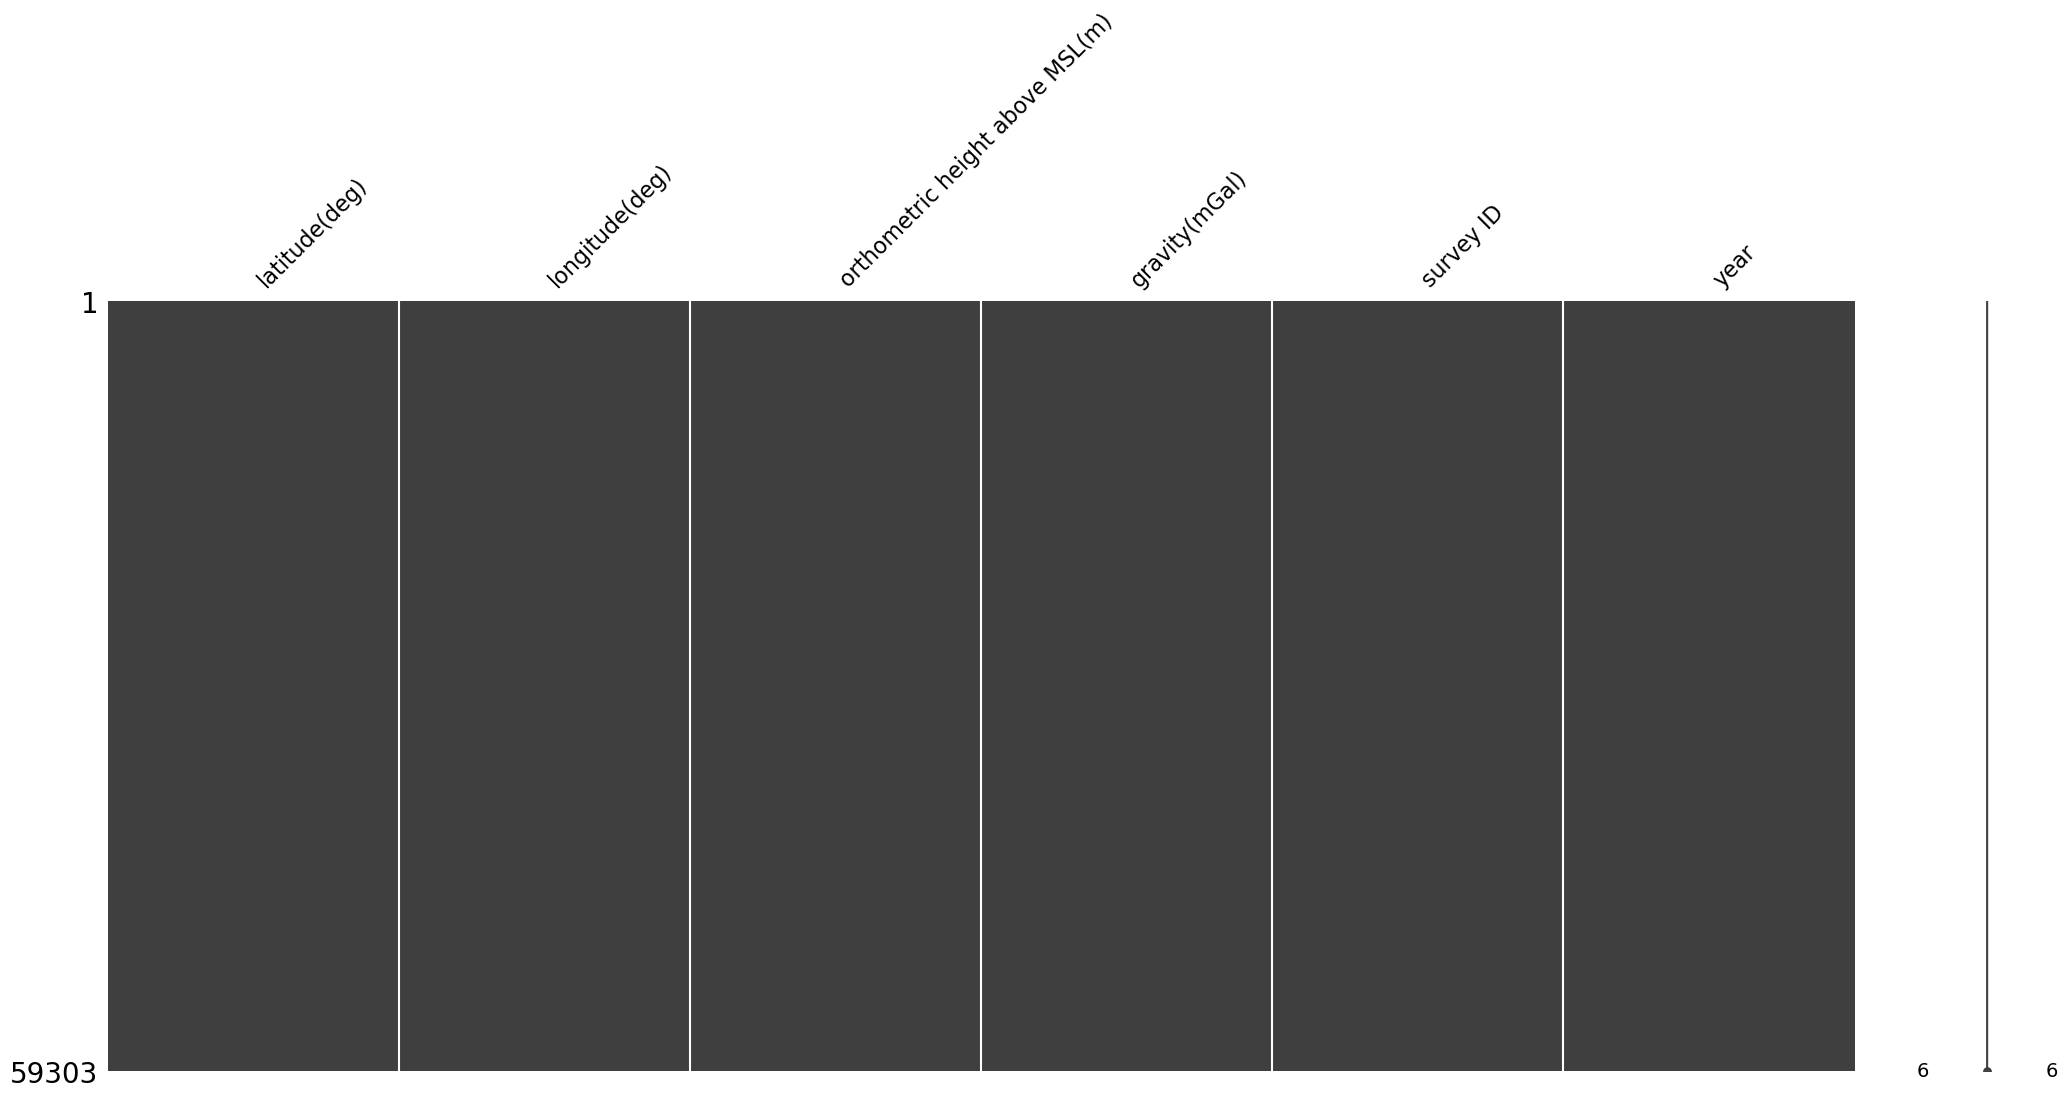

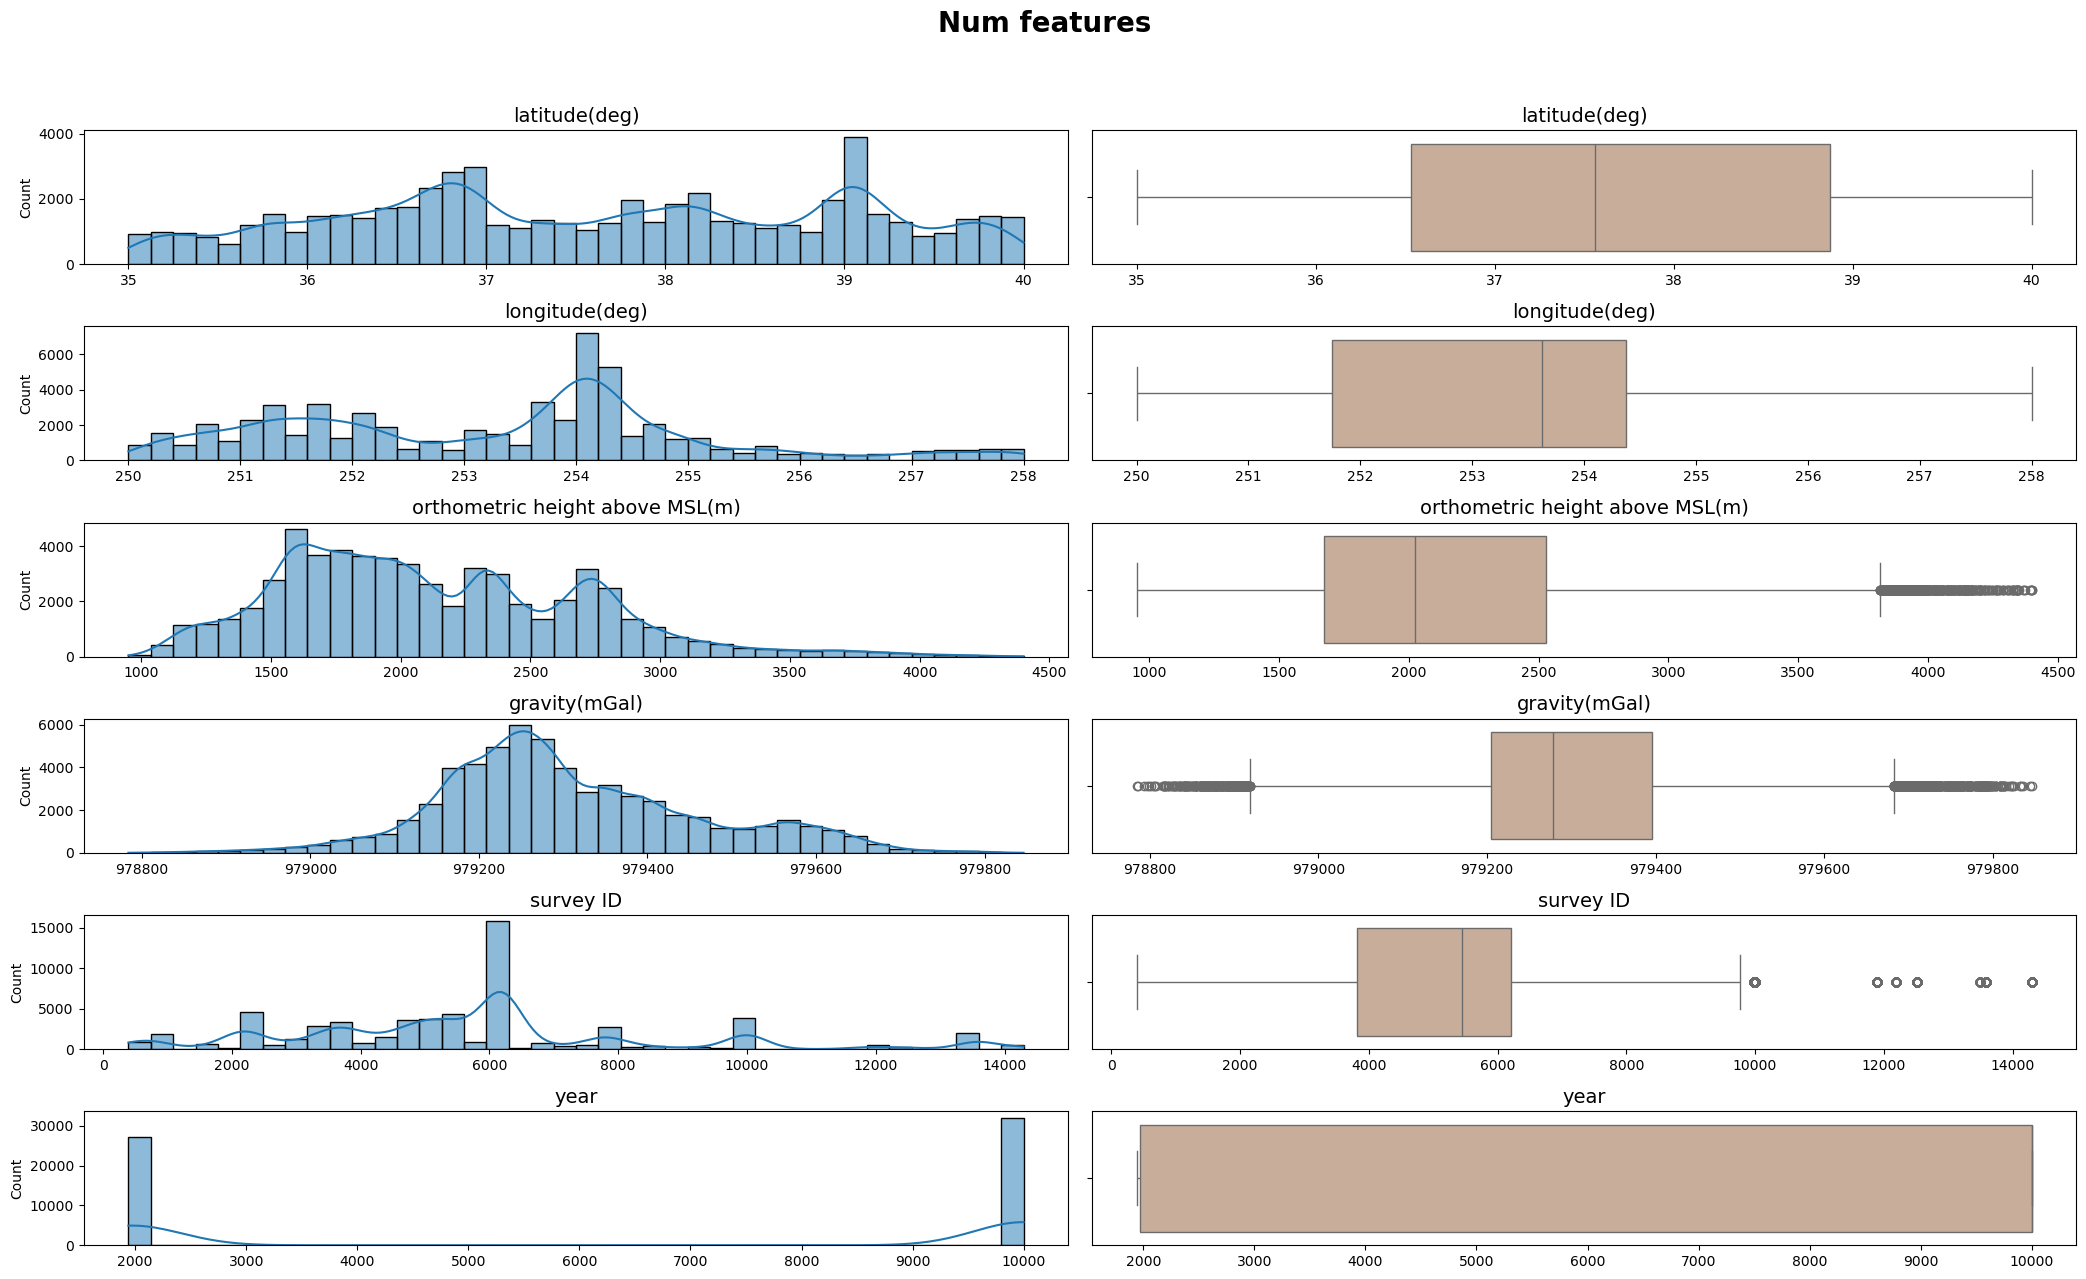

<Figure size 1500x1300 with 0 Axes>

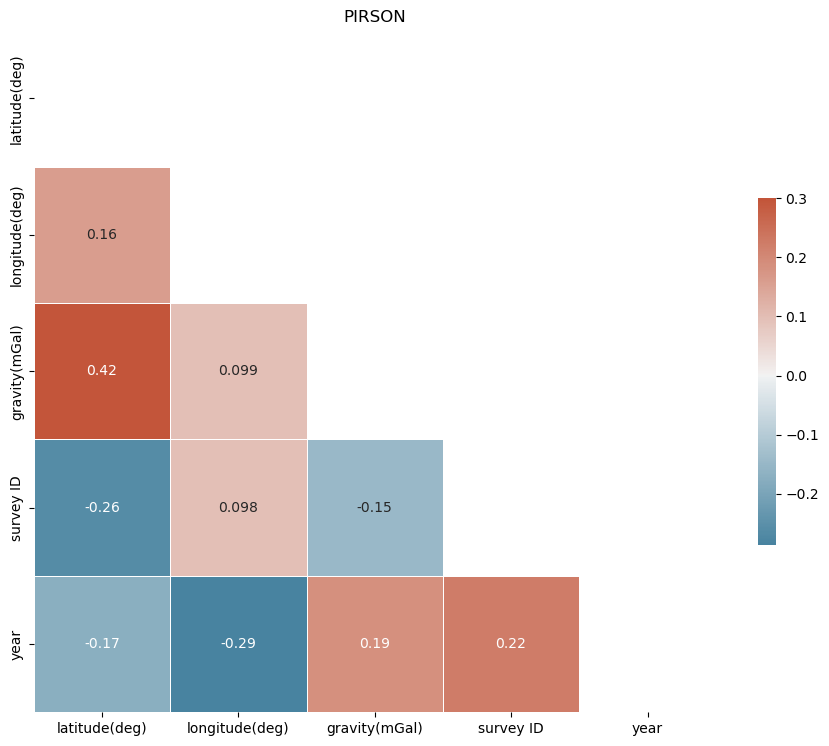

<Figure size 1500x1300 with 0 Axes>

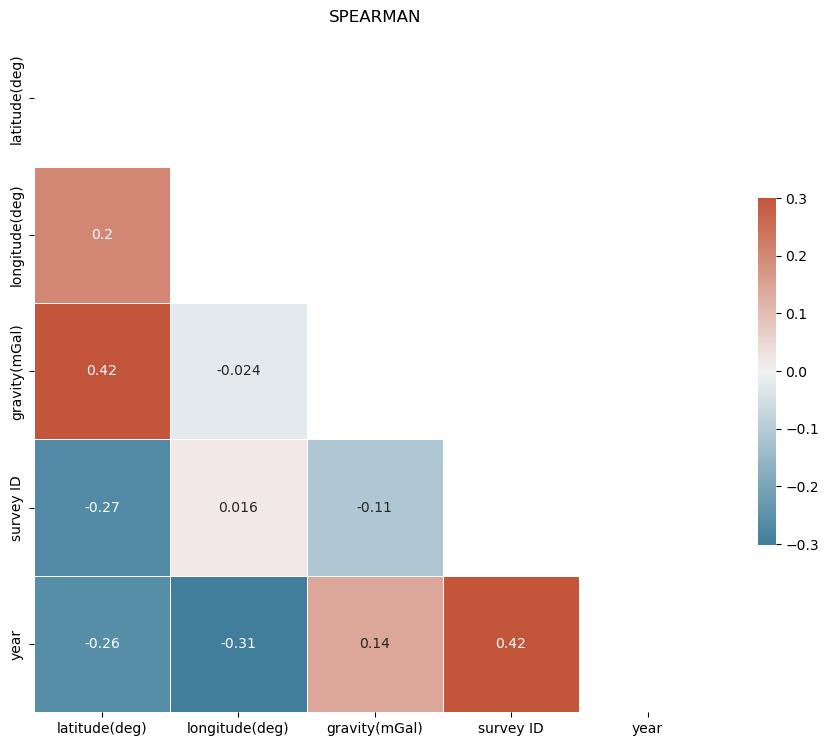

<Figure size 1500x1300 with 0 Axes>

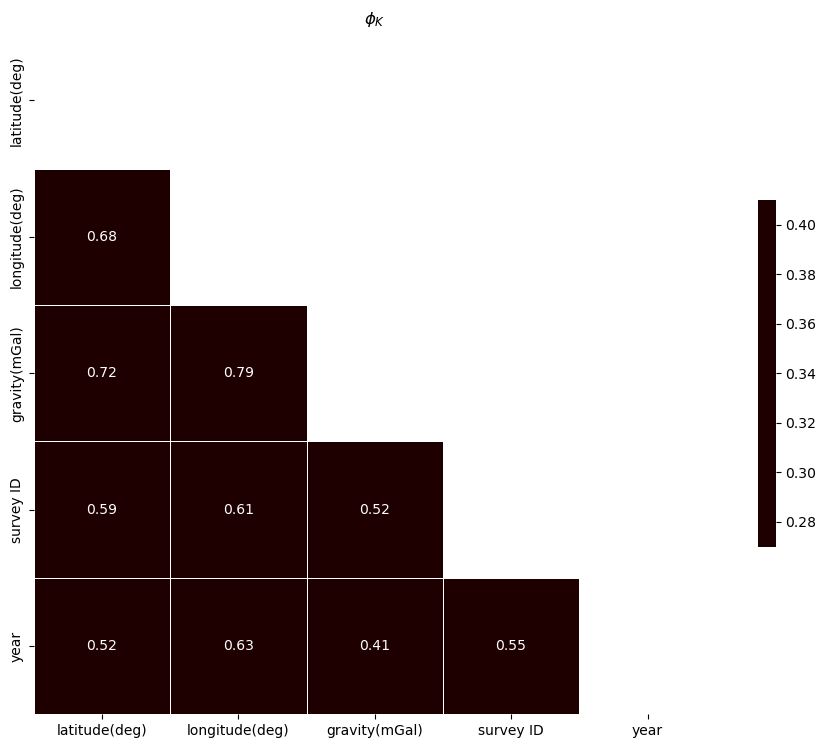

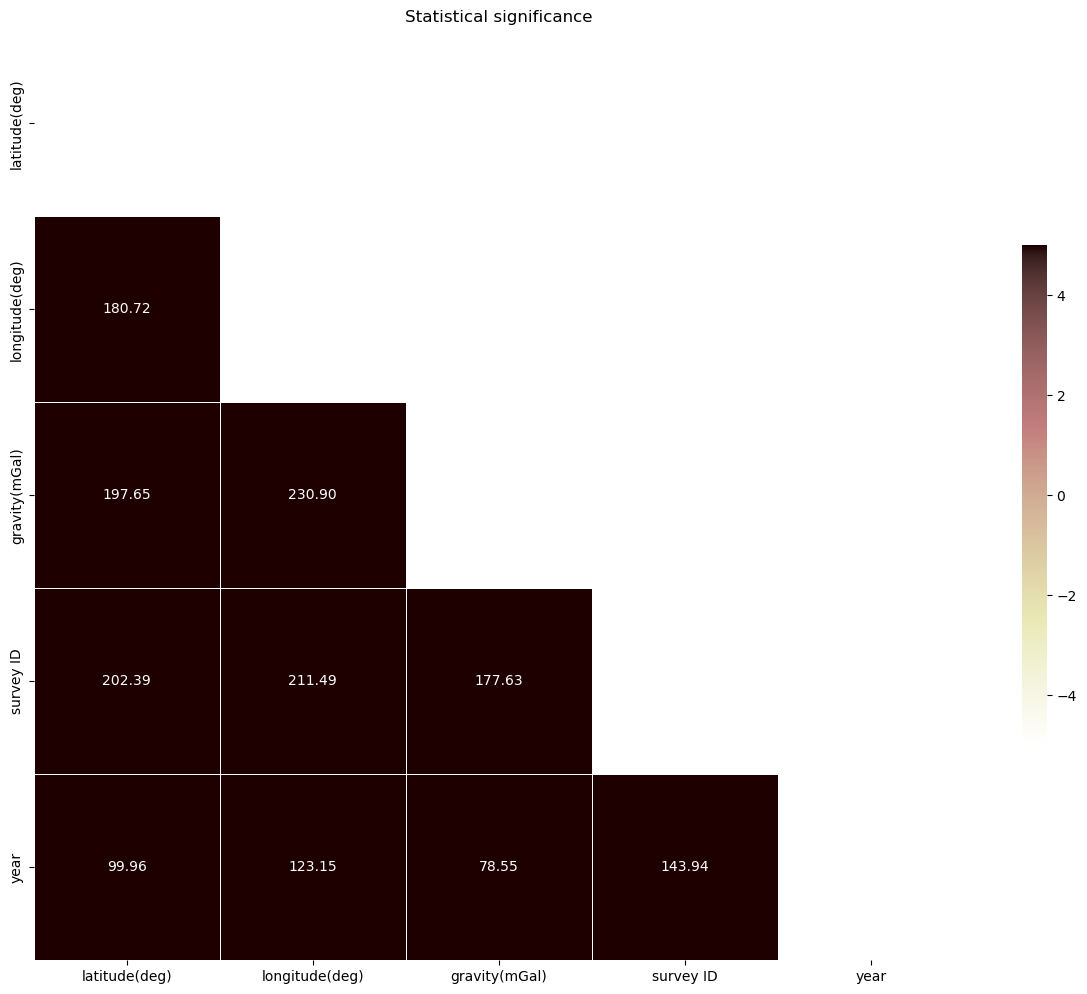

In [10]:
for data in [loader.train]:
    DataAnalysis.info_df(data)
    DataAnalysis.blinks(data)
    DataAnalysis.view_distribution(data, numeric_col=True)
    DataAnalysis.correlations(data)

In [11]:
DataAnalysis.summary(loader.train).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count,skew
latitude(deg),float16,0,0.000000,161,59303,-0.029663
longitude(deg),float16,0,0.000000,57,59303,0.364014
orthometric height above MSL(m),float16,0,0.000000,2107,59303,nan
gravity(mGal),float32,0,0.000000,11350,59303,0.463978
survey ID,int16,0,0.000000,137,59303,0.848635
year,int16,0,0.000000,41,59303,-0.161778


In [12]:
loader.train.describe().T\
            .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
            .background_gradient(subset=['std'], cmap='Blues')\
            .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
latitude(deg),59303.000000,inf,1.351562,35.000000,36.531250,37.562500,38.875000,40.000000
longitude(deg),59303.000000,inf,1.832031,250.000000,251.750000,253.625000,254.375000,258.000000
orthometric height above MSL(m),59303.000000,inf,inf,950.500000,1674.000000,2023.000000,2530.000000,4400.000000
gravity(mGal),59303.000000,979307.437500,324.654388,978784.250000,979205.375000,979278.125000,979396.250000,979846.250000
survey ID,59303.000000,5720.492252,2870.721419,393.000000,3814.000000,5451.000000,6209.000000,14295.000000
year,59303.000000,6309.643070,3999.850664,1939.000000,1972.000000,9999.000000,9999.000000,9999.000000


# Features

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    loader.train.drop(columns=CFG.TARGET), loader.train[CFG.TARGET], test_size=0.33, random_state=CFG.RANDOM_STATE)

# Baseline CatBoost

In [14]:
from catboost import *
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

In [15]:
cat_features = X_train.select_dtypes(include=['category','object']).columns.to_list()

In [18]:
def build_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'depth': trial.suggest_int('depth', 1, 10),
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'task_type': 'GPU',
    }


    model = CatBoostRegressor(**params, silent=True, random_state=CFG.RANDOM_STATE)
    cv_data = cv(
        Pool(X_train, y_train, cat_features=cat_features),
        model.get_params(),
        early_stopping_rounds=100
    )
    return np.mean(cv_data['test-RMSE-mean'])

In [19]:
study = optuna.create_study(direction="minimize")
study.optimize(build_catboost, n_trials=CFG.N_FOLDS)

[I 2025-06-04 14:35:37,426] A new study created in memory with name: no-name-197f1203-2056-4c25-8e35-252a5e0fa2e4


Training on fold [0/3]
bestTest = 61.8498529
bestIteration = 331
Training on fold [1/3]
bestTest = 63.8062015
bestIteration = 328
Training on fold [2/3]


[I 2025-06-04 14:35:51,759] Trial 0 finished with value: 186.31119949978913 and parameters: {'iterations': 332, 'learning_rate': 0.04989112985789219, 'depth': 6}. Best is trial 0 with value: 186.31119949978913.


bestTest = 65.45783743
bestIteration = 331
Training on fold [0/3]
bestTest = 48.9065472
bestIteration = 870
Training on fold [1/3]
bestTest = 58.49392888
bestIteration = 788
Training on fold [2/3]


[I 2025-06-04 14:36:26,256] Trial 1 finished with value: 99.70492806513097 and parameters: {'iterations': 871, 'learning_rate': 0.060293871694498714, 'depth': 6}. Best is trial 1 with value: 99.70492806513097.


bestTest = 61.05394182
bestIteration = 870
Training on fold [0/3]
bestTest = 56.76217564
bestIteration = 945
Training on fold [1/3]
bestTest = 58.16170867
bestIteration = 945
Training on fold [2/3]


[I 2025-06-04 14:37:28,245] Trial 2 finished with value: 164.4606978456274 and parameters: {'iterations': 946, 'learning_rate': 0.02058571349930568, 'depth': 9}. Best is trial 1 with value: 99.70492806513097.


bestTest = 61.40218014
bestIteration = 945
Training on fold [0/3]
bestTest = 54.29509571
bestIteration = 770
Training on fold [1/3]
bestTest = 59.81189683
bestIteration = 505
Training on fold [2/3]


[I 2025-06-04 14:38:04,010] Trial 3 finished with value: 104.49872863502034 and parameters: {'iterations': 771, 'learning_rate': 0.05631445987883668, 'depth': 9}. Best is trial 1 with value: 99.70492806513097.


bestTest = 59.47267519
bestIteration = 770
Training on fold [0/3]
bestTest = 51.55546259
bestIteration = 666
Training on fold [1/3]
bestTest = 58.06838364
bestIteration = 658
Training on fold [2/3]


[I 2025-06-04 14:38:28,052] Trial 4 finished with value: 100.62599640169171 and parameters: {'iterations': 668, 'learning_rate': 0.08170252079854033, 'depth': 4}. Best is trial 1 with value: 99.70492806513097.


bestTest = 56.04096045
bestIteration = 667


In [20]:
best_params = study.best_params
best_params

{'iterations': 871, 'learning_rate': 0.060293871694498714, 'depth': 6}

In [21]:
rmses = []
preds = []

skf = KFold(n_splits=5, shuffle=True, random_state=CFG.RANDOM_STATE)

for CFG.N_FOLDS, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
    print(f'### Fold {CFG.N_FOLDS+1} Training ###')
    X_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    X_v = X_train.iloc[valid_idx]
    y_v = y_train.iloc[valid_idx]

    X_train_pool = Pool(X_t, y_t, cat_features=cat_features)
    X_valid_pool = Pool(X_v, y_v, cat_features=cat_features)
    
    model = CatBoostRegressor(
        eval_metric='RMSE',
        learning_rate=best_params['learning_rate'],
        iterations=best_params['iterations'],
        depth=best_params['depth'],
        task_type='GPU',
        random_seed=CFG.RANDOM_STATE,
        verbose=False
    )

    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=500, early_stopping_rounds=50)

    preds.append(model.predict(X_valid_pool))

    rmse = root_mean_squared_error(y_v, model.predict(X_valid_pool))
    rmses.append(rmse)

    print(f'Fold {CFG.N_FOLDS+1} RMSE: {rmse:.5f}\n')

print(f'\nOverall RMSE: {np.mean(rmses):.5f} +/- {np.std(rmses):.5f}')

### Fold 1 Training ###
0:	learn: 547.1903370	test: 549.4444760	best: 549.4444760 (0)	total: 16.8ms	remaining: 14.6s
500:	learn: 46.0014362	test: 45.5096125	best: 45.5096125 (500)	total: 6.91s	remaining: 5.1s
870:	learn: 41.5350077	test: 41.2794389	best: 41.2794389 (870)	total: 11.7s	remaining: 0us
bestTest = 41.27943886
bestIteration = 870
Fold 1 RMSE: 41.27948

### Fold 2 Training ###
0:	learn: 547.9043695	test: 546.3082805	best: 546.3082805 (0)	total: 15.1ms	remaining: 13.2s
500:	learn: 52.2210838	test: 52.8157882	best: 52.8157882 (500)	total: 6.42s	remaining: 4.74s
870:	learn: 46.5687566	test: 47.5117782	best: 47.5117782 (870)	total: 10.8s	remaining: 0us
bestTest = 47.51177822
bestIteration = 870
Fold 2 RMSE: 47.51172

### Fold 3 Training ###
0:	learn: 546.0591937	test: 553.5916056	best: 553.5916056 (0)	total: 20.7ms	remaining: 18s
500:	learn: 49.5747651	test: 51.8579212	best: 51.8579212 (500)	total: 6.47s	remaining: 4.78s
bestTest = 48.69152367
bestIteration = 819
Shrink model to 

In [23]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

# Ваши данные
longitudes = loader.train['longitude(deg)']
latitudes = loader.train['latitude(deg)']
heights = loader.train[CFG.TARGET]

# Интерполяция
grid_x, grid_y = np.mgrid[
    min(longitudes):max(longitudes):100j,
    min(latitudes):max(latitudes):100j
]
grid_z = griddata(
    (longitudes, latitudes), heights, (grid_x, grid_y), method='cubic'
)

# Создаем 3D-поверхность
fig = go.Figure(data=[go.Surface(
    x=grid_x, y=grid_y, z=grid_z,
    colorscale='Viridis',
    opacity=0.8,
    contours_z=dict(show=True, usecolormap=True))
])

# Настройки макета
fig.update_layout(
    title='3D Gravity Surface',
    scene=dict(
        xaxis_title='Longitude (deg)',
        yaxis_title='Latitude (deg)',
        zaxis_title='Gravity (mGal)',
    ),
    autosize=False,
    width=900,
    height=700,
)

fig.show()

In [24]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

# Ваши данные
longitudes = X_test['longitude(deg)']
latitudes = X_test['latitude(deg)']
heights = model.predict(X_test) - y_test

# Интерполяция
grid_x, grid_y = np.mgrid[
    min(longitudes):max(longitudes):100j,
    min(latitudes):max(latitudes):100j
]
grid_z = griddata(
    (longitudes, latitudes), heights, (grid_x, grid_y), method='cubic'
)

# Создаем 3D-поверхность
fig = go.Figure(data=[go.Surface(
    x=grid_x, y=grid_y, z=grid_z,
    colorscale='Viridis',
    opacity=0.8,
    contours_z=dict(show=True, usecolormap=True))
])

# Настройки макета
fig.update_layout(
    title='3D Gravity Surface',
    scene=dict(
        xaxis_title='Longitude (deg)',
        yaxis_title='Latitude (deg)',
        zaxis_title='Gravity (mGal)',
    ),
    autosize=False,
    width=900,
    height=700,
)

fig.show()

In [25]:
pd.DataFrame(model.predict(X_test) - y_test).describe().T\
            .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
            .background_gradient(subset=['std'], cmap='Blues')\
            .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
orthometric height above MSL(m),19570.000000,0.106860,42.927712,-493.105882,-21.995312,1.088533,22.866890,329.936616


# Baseline NN

In [ ]:
from sklearn.preprocessing import (
    MinMaxScaler, 
    StandardScaler,
    RobustScaler
)

In [ ]:
# 1. Выполним разделение и масштабирование
X_temp, X_test, y_temp, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=CFG.RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=CFG.RANDOM_STATE)

# 2. Масштабирование только числовых признаков
numeric_cols = X_train.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns

sc = MinMaxScaler()
X_train[numeric_cols] = sc.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = sc.transform(X_val[numeric_cols])
X_test[numeric_cols] = sc.transform(X_test[numeric_cols])